In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers

pd.options.display.max_rows=10
pd.options.display.float_format="{:.1f}".format

e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym

In [2]:
train_df=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df=train_df.reindex(np.random.permutation(train_df.index))

In [3]:
train_df_mean=train_df.mean()
train_df_std=train_df.std()
train_df_norm=(train_df - train_df_mean)/train_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1699,1.2,-1.3,1.1,-0.2,-0.4,-0.4,-0.3,0.9,0.8
12264,-1.0,1.4,1.9,-0.4,-0.5,-0.7,-0.5,0.1,-0.3
5745,0.7,-0.8,0.4,-0.5,-0.4,0.3,-0.4,-1.0,-0.6
10454,-0.4,1.1,-1.2,-0.2,-0.3,-0.4,-0.3,-0.8,-0.3
3502,0.8,-0.8,-0.0,0.0,-0.5,-0.4,-0.4,2.7,1.4


In [4]:
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [5]:
threshold=265000
train_df_norm["median_house_value_is_high"]=(train_df["median_house_value"]>threshold).astype(float)
test_df_norm["median_house_value_is_high"]=(test_df["median_house_value"]>threshold).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)

1699    1.0
12264   0.0
5745    0.0
10454   0.0
3502    1.0
         ..
13926   1.0
12428   0.0
7455    1.0
13276   0.0
6022    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
feature_columns=[]
median_income=tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

tr=tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

feature_layer=layers.DenseFeatures(feature_columns)

feature_layer(dict(train_df_norm))

Instructions for updating:
Use `tf.cast` instead.


<tf.Tensor: id=26, shape=(17000, 2), dtype=float32, numpy=
array([[ 0.8622573 , -0.1961811 ],
       [ 0.13789324, -0.44022372],
       [-1.0460767 , -0.53472143],
       ...,
       [ 0.5195705 , -0.6498618 ],
       [-0.16899982,  1.0648587 ],
       [ 0.07222778,  0.7905401 ]], dtype=float32)>

In [7]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    model=tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                   activation=tf.sigmoid),)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate), 
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=my_metrics)
    return model

def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    features={name:np.array(value) for name, value in dataset.items()}
    label=np.array(features.pop(label_name))
    history=model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=shuffle)
    epochs=history.epoch
    hist=pd.DataFrame(history.history)
    return epochs, hist

In [8]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
    
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    for m in list_of_metrics:
        
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

Epoch 1/20
17000/17000 [==============================] - 5s 280us/sample - loss: 0.5330 - accuracy: 0.5655 - precision: 0.3572 - recall: 0.9244
Epoch 2/20
17000/17000 [==============================] - 5s 296us/sample - loss: 0.4963 - accuracy: 0.6354 - precision: 0.3964 - recall: 0.8794
Epoch 3/20
17000/17000 [==============================] - 5s 315us/sample - loss: 0.4673 - accuracy: 0.6821 - precision: 0.4297 - recall: 0.8328
Epoch 4/20
17000/17000 [==============================] - 5s 309us/sample - loss: 0.4447 - accuracy: 0.7191 - precision: 0.4635 - recall: 0.7909
Epoch 5/20
17000/17000 [==============================] - 5s 282us/sample - loss: 0.4274 - accuracy: 0.7428 - precision: 0.4903 - recall: 0.7523s - loss: 0.4286 - accuracy: 0.7430 - precision: 0.4946 - recall
Epoch 6/20
17000/17000 [==============================] - 5s 286us/sample - loss: 0.4150 - accuracy: 0.7667 - precision: 0.5245 - recall: 0.7078s - loss: 0.4097 - a
Epoch 7/20
17000/17000 [======================

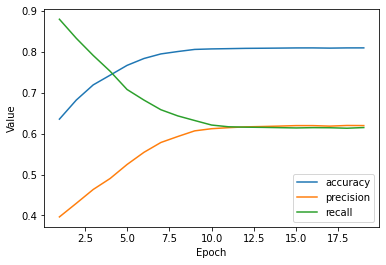

In [11]:
learning_rate=0.001
epochs=20
batch_size=100
label_name="median_house_value_is_high"
classification_threshold=0.35

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

In [10]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

3000/3000 [==============================] - 0s 32us/sample - loss: 0.4068 - accuracy: 0.8003


[0.40675135254859923, 0.8003333]